# Download, crop and save OSTIA

OSTIA dataset & dataset id:

https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/services

`conda install copernicusmarine`

In [39]:
import os
import glob
import tempfile
from pathlib import Path

import copernicusmarine
import xarray as xr
import rioxarray
import geopandas as gpd

In [4]:
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw/')

## Login and download

In [9]:
copernicusmarine.login()

username:

  rwegener


password:

  ········


File /Users/rwegener/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2025-02-24T01:52:37Z - Credentials file stored in /Users/rwegener/.copernicusmarine/.copernicusmarine-credentials.


True

In [10]:
dataset_id = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'

datasets = copernicusmarine.describe(
   include_datasets = True, 
   contains = [dataset_id]
)

WARNING - 2025-02-24T01:52:47Z - Deprecation warning for option 'include_datasets'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|████████████████████| 3/3 [00:26<00:00,  8.82s/it]


In [14]:
# Create temporary directory for storing un-cropped raw data
scratch_dir = tempfile.TemporaryDirectory()

In [16]:
copernicusmarine.subset(
    dataset_id = dataset_id,
    variables = ["analysed_sst"],
    start_datetime = "2003-01-01T00:00:00",
    end_datetime = "2023-12-31T00:00:00",
    minimum_longitude = -77.5,
    maximum_longitude = -75.5, 
    minimum_latitude = 36.75,
    maximum_latitude = 40,
    output_directory = scratch_dir.name,
)
# '20020901', '20230831'
# lat=slice(36.75, 40), lon=slice(-77.5, -75.5)

INFO - 2025-02-24T01:56:19Z - Dataset version was not specified, the latest one was selected: "default"
INFO - 2025-02-24T01:56:19Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-02-24T01:56:21Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2025-02-24T01:56:24Z - Some or all of your subset selection [2003-01-01 00:00:00, 2023-12-31 00:00:00] for the time dimension  exceed the dataset coordinates [2007-01-01 00:00:00, 2025-02-22 00:00:00]
INFO - 2025-02-24T01:56:24Z - Downloading using service arco-time-series...
INFO - 2025-02-24T01:56:26Z - <xarray.Dataset>
Dimensions:       (time: 6209, latitude: 65, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude     (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
  * time          (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
Data variables:
    analysed_sst  (time, latitude, l

  Y


INFO - 2025-02-24T01:56:32Z - Writing to local storage. Please wait...
100%|█████████████████████████████████| 377/377 [00:02<00:00, 132.77it/s]
INFO - 2025-02-24T01:56:36Z - Successfully downloaded to /var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/tmpza89drxt/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc


PosixPath('/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/tmpza89drxt/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc')

In [26]:
downloaded_files = glob.glob(scratch_dir.name + '/*.nc')
if len(downloaded_files) > 1:
    raise Exception('Only 1 file should be downloaded from Copernicus')
else:
    filepath = downloaded_files[0]

## Open and crop the dataset

In [40]:
# Create the geopandas dataframe of the Chesapeake Bay shape for masking
cbay_wkt = (
    'POLYGON ((-75.07331635657022 36.69945277755481,' 
    '-75.07331761665449 38.10656782772858, -75.37020665599995 38.29321651673962,'  
    '-75.7561692781297 39.85271304991599, -77.9036114835175 39.860284284356595,'
    '-77.9432159124284 36.7312001366339, -75.07331635657022 36.69945277755481))'
)
cbay_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt([cbay_wkt]), 
                            crs='EPSG:4326')

In [44]:
ds = xr.open_dataset(filepath)
# set CRS (prerequisite for masking)
ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:       (time: 6209, latitude: 65, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude     (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
  * time          (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
    spatial_ref   int64 0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              enquiries@metoffice.gov.uk
    ...                         ...
    time_coverage_end:          20240119T000000Z
    time_coverage_start:        20240118T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       536d4865-f5a8-45b2-806f-1f1db491069a
    westernmost_longitude:      -180.0
    copernicusmarine_version:   1.3.5

In [51]:
# Subset and mask out the Delaware Bay
ds_chesapeake = ds.sel(latitude=slice(36.75, 40), longitude=slice(-77.5, -75.5))

In [55]:
ds_chesapeake

<xarray.Dataset>
Dimensions:       (time: 6209, latitude: 65, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * longitude     (longitude) float32 -77.47 -77.43 -77.38 ... -75.57 -75.53
  * time          (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
    spatial_ref   int64 0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              enquiries@metoffice.gov.uk
    ...                         ...
    time_coverage_end:          20240119T000000Z
    time_coverage_start:        20240118T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       536d4865-f5a8-45b2-806f-1f1db491069a
    westernmost_longitude:      -180.0
    copernicusmarine_version:   1.3.5

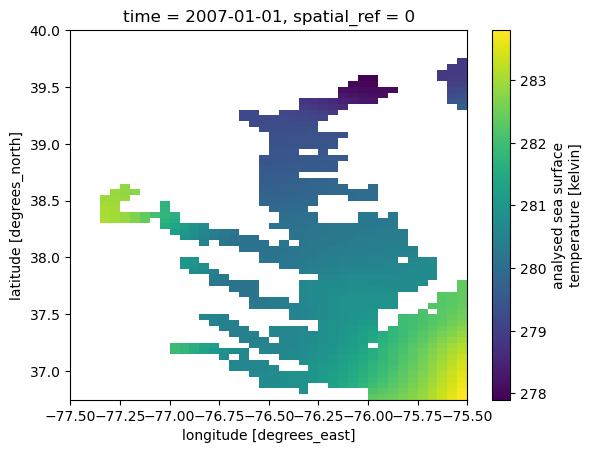

In [53]:
ds_chesapeake.analysed_sst.isel(time=0).plot()

In [54]:
ds_chesapeake = ds_chesapeake.rio.clip(
    cbay_gdf.geometry.values, cbay_gdf.crs, drop=False
)

ImportError: cannot import name '_coordinates_from_variable' from 'xarray.core.coordinates' (/Users/rwegener/miniconda3/envs/copernicusmarine/lib/python3.12/site-packages/xarray/core/coordinates.py)

In [49]:
import pandas as pd

In [50]:
pd.date_range('2007-01-01', '2023-12-31')

DatetimeIndex(['2007-01-01', '2007-01-02', '2007-01-03', '2007-01-04',
               '2007-01-05', '2007-01-06', '2007-01-07', '2007-01-08',
               '2007-01-09', '2007-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=6209, freq='D')

In [47]:
ds_chesapeake.time

<xarray.DataArray 'time' (time: 6209)>
array(['2007-01-01T00:00:00.000000000', '2007-01-02T00:00:00.000000000',
       '2007-01-03T00:00:00.000000000', ..., '2023-12-29T00:00:00.000000000',
       '2023-12-30T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
    spatial_ref  int64 0
Attributes:
    valid_min:  820454400
    valid_max:  1356825600

In [57]:
ds_chesapeake.to_netcdf(
    REPO_ROOT / 'data/02_interim' / 
    'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc'
)

In [56]:
filepath

'/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/tmpza89drxt/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-12-31.nc'

In [58]:
# Delete the temporary directory
scratch_dir.cleanup()

In [33]:
ds.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 6209, latitude: 65, longitude: 40)>
[16143400 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 36.78 36.83 36.88 36.92 ... 39.88 39.92 39.97
  * longitude  (longitude) float32 -77.47 -77.43 -77.38 ... -75.62 -75.57 -75.53
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2023-12-31
Attributes:
    comment:         OSTIA foundation SST
    coordinates:    lon lat
    long_name:      analysed sea surface temperature
    reference:      Good S, Fiedler E, Mao C, Martin MJ, Maycock A, Reid R, R...
    source:         AVHRR18_G-NAVO-L2P-V1.0, AVHRR19_G-NAVO-L2P-V1.0, AVHRR_S...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

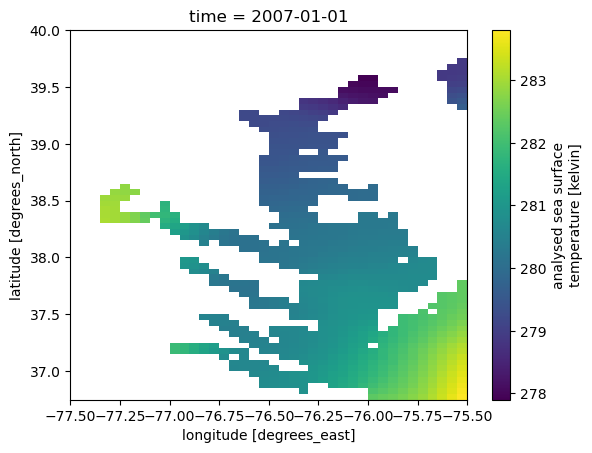

In [34]:
ds.analysed_sst.isel(time=0).plot()

## Save the output